### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_ASTER.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
# arrFeatures = arrFeatures.astype(float)
arrFeatures = np.float16(arrFeatures)

# dsFeatures.__dict__

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    # plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)
    plot_array(arrFeatures[band-1, :, :], f'Band {band}')

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output()), _…

### Generating chips

In [4]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

# create chips using pyrsgis
features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=5, y_size=5)

### Loading the training dataset (manual)

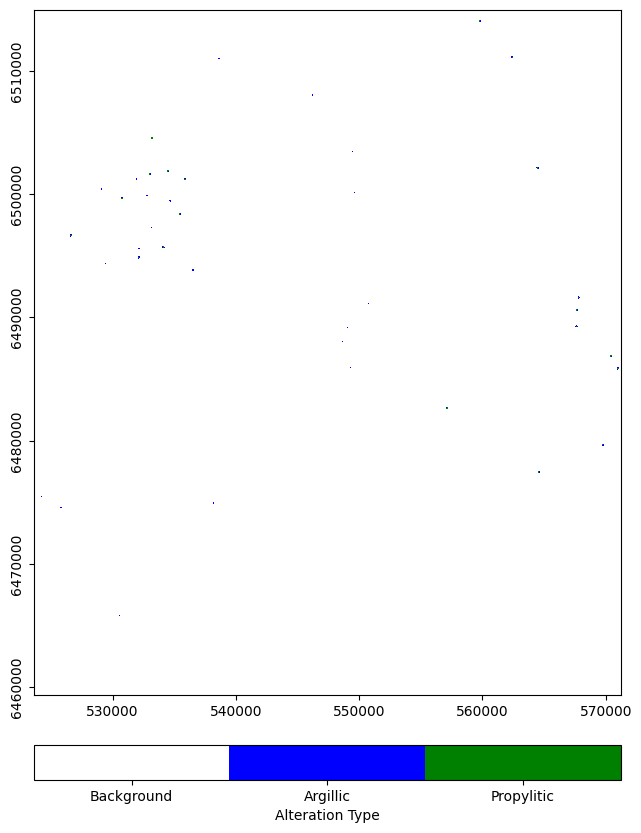

In [5]:
positiveLabel_file = './BrokenHill_ASTER_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

### Splitting features and labels into training and test datasets

In [7]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

In [8]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=10)
# predict for the test dataset
yTestPredicted = model.predict(test_x)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/10
134/134 [==============================] - 2s 4ms/step - loss: 0.9889 - accuracy: 0.4905
Epoch 2/10
134/134 [==============================] - 1s 6ms/step - loss: 0.6719 - accuracy: 0.6875
Epoch 3/10
134/134 [==============================] - 1s 5ms/step - loss: 0.5303 - accuracy: 0.7685
Epoch 4/10
134/134 [==============================] - 0s 4ms/step - loss: 0.4178 - accuracy: 0.8264
Epoch 5/10
134/134 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8804
Epoch 6/10
134/134 [==============================] - 0s 3ms/step - loss: 0.2422 - accuracy: 0.9123
Epoch 7/10
134/134 [==============================] - 1s 5ms/step - loss: 0.1989 - accuracy: 0.9329
Epoch 8/10
134/134 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.9404
Epoch 9/10
134/134 [==============================] - 1s 4ms/step - loss: 0.1596 - accuracy: 0.9479
Epoch 10/10
58/58 [==============================] - 0s 2ms/step
Confusion matrix:
 [[617   0   0]
 

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

### Mapping alteration zones

367904/367904 [==============================] - 717s 2ms/step


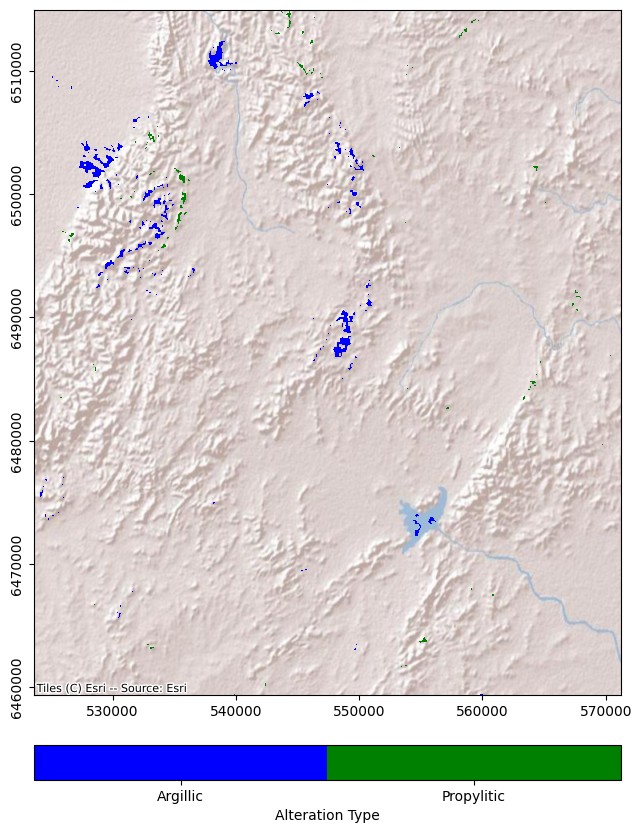

In [9]:
# del features_chips
# del arrFeatures_fuzzy
# del arrFeatures

# # load and normalize a new multispectral image
# dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
# # arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
# arrPred_fuzzy = np.zeros(arrPred.shape)

# for i in range(arrPred.shape[0]):
#     bandMin = arrPred[i, :, :].min()
#     bandMax = arrPred[i, :, :].max()
#     bandRange = bandMax-bandMin
#     for j in range(arrPred.shape[1]):
#         for k in range(arrPred.shape[2]):
#             arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# # generate image chips from the array
# pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

pred_features_chips = features_chips
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_ASTER_Manual_CNN_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

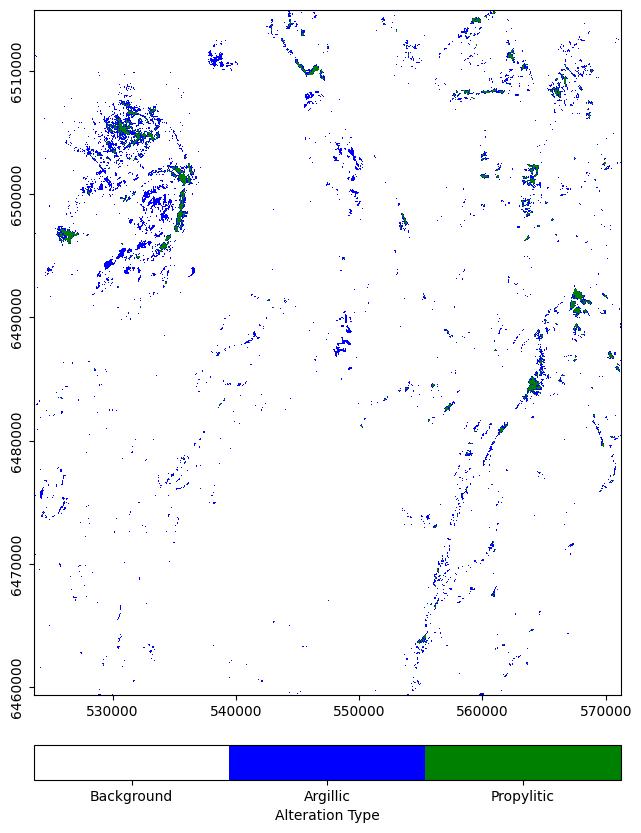

In [10]:
positiveLabel_file = './BrokenHill_ASTER_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [11]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

### Splitting features and labels into training and test datasets

In [12]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

In [13]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=10)
# predict for the test dataset
yTestPredicted = model.predict(test_x)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/10
12873/12873 [==============================] - 335s 26ms/step - loss: 0.3862 - accuracy: 0.8438
Epoch 2/10
12873/12873 [==============================] - 332s 26ms/step - loss: 0.2707 - accuracy: 0.9065
Epoch 3/10
12873/12873 [==============================] - 328s 25ms/step - loss: 0.2451 - accuracy: 0.9218
Epoch 4/10
12873/12873 [==============================] - 321s 25ms/step - loss: 0.2318 - accuracy: 0.9274
Epoch 5/10
12873/12873 [==============================] - 341s 27ms/step - loss: 0.2280 - accuracy: 0.9330
Epoch 6/10
12873/12873 [==============================] - 320s 25ms/step - loss: 0.2268 - accuracy: 0.9358
Epoch 7/10
12873/12873 [==============================] - 336s 26ms/step - loss: 0.2298 - accuracy: 0.9346
Epoch 8/10
12873/12873 [==============================] - 336s 26ms/step - loss: 0.2300 - accuracy: 0.9353
Epoch 9/10
12873/12873 [==============================] - 334s 26ms/step - loss: 0.2223 - accuracy: 0.9364
Epoch 10/10
5517/5517 [==============

### Mapping alteration zones

367904/367904 [==============================] - 2209s 6ms/step


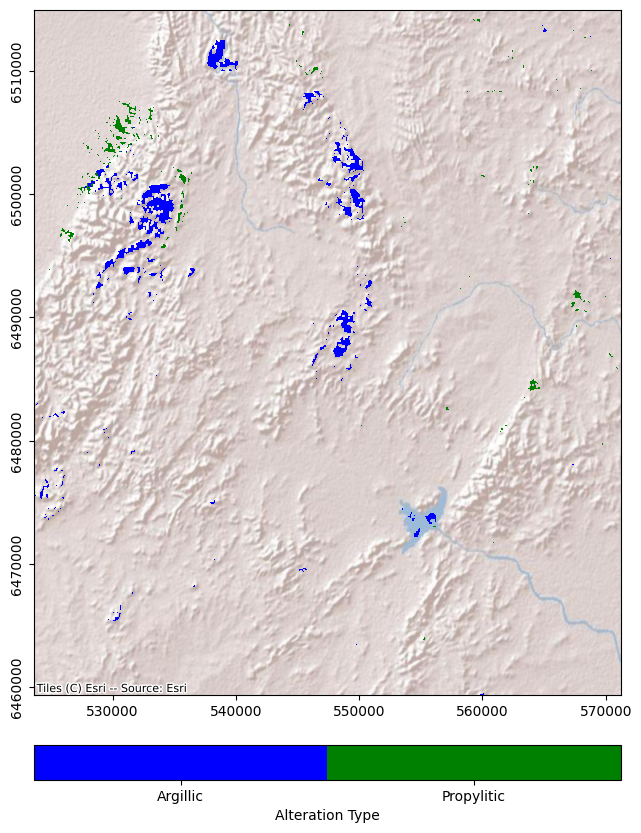

In [14]:
# del features_chips
# del arrFeatures_fuzzy
# del arrFeatures

# # load and normalize a new multispectral image
# dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
# # arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
# arrPred_fuzzy = np.zeros(arrPred.shape)

# for i in range(arrPred.shape[0]):
#     bandMin = arrPred[i, :, :].min()
#     bandMax = arrPred[i, :, :].max()
#     bandRange = bandMax-bandMin
#     for j in range(arrPred.shape[1]):
#         for k in range(arrPred.shape[2]):
#             arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# # generate image chips from the array
# pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

pred_features_chips = features_chips
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_ASTER_PCA_CNN_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')